# Hometask 03
### Maksim Sorokin

#### Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
Cохранить ее в pandas dataframe, а также в excel, pickle, БД

Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.

In [354]:
import requests
import pandas as pd
import openpyxl
from tqdm import tqdm
from pandas import DataFrame
from sqlalchemy import create_engine
import os.path
import matplotlib.pyplot as plt
import seaborn as sns

In [355]:
class DomRfRestClient:

    def getTotal(self):
        url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset=1&limit=100&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
        res = requests.get(url)
        return res.json().get('data').get('total')

    def getIds(self,offset_ = 1, limit_ = 100):
        url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
        res = requests.get(url)
        objects_data = res.json()
        objects_data.get('data').get('list')[0]
        objects_list = objects_data.get('data').get('list')
        l = list()
        for a in objects_list:
            l.append(a['objId'])
        return l

    def get_object_by_id(self, id):
        url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{id}'
        answ = requests.get(url)
        return answ.json()
    

In [356]:
class DomRfDataLoader:

    client: DomRfRestClient
    
    def __init__(self,a:DomRfRestClient):
        self.client = a

    def get_all_ids(self):
        all_objects_list = list()
        total_objects =  self.client.getTotal()
        iterations = total_objects // 100
        print('Expected iterations count: ')
        if (total_objects % 100) > 0:
            iterations+=1

        for a in tqdm(range(iterations)):
            all_objects_list.extend(self.client.getIds(a*100))

        assert len(all_objects_list) == total_objects, 'Didn\'t load the whole dataset'
        print('Loaded '+str(len(all_objects_list)) + ' entries, total '+str(total_objects))
        return all_objects_list

    def get_all_objects(self):
        all_objects_full_list = list()
        ids_with_errors = list()
        for a in tqdm(self.get_all_ids()):
            try:
                all_objects_full_list.append(self.client.get_object_by_id(a))
            except:
                ids_with_errors.append(a)

        print('Additional processing of failed ids')
        for b in tqdm(ids_with_errors):
            all_objects_full_list.append(self.client.get_object_by_id(b))

        assert len(all_objects_full_list) == self.client.getTotal(), 'Didn\'t load the whole dataset'
        return all_objects_full_list

In [357]:
class DomRfDataSaver:
    elements: list
    internal_df: DataFrame
    
    def __init__(self, l):
        self.elements = l
        print('len self.elements: '+str(len(self.elements)))
        self.internal_df = DataFrame()
        for c in tqdm(self.elements):
            temp_result_dict = dict(c.get('data'))
            developer_dict = temp_result_dict.get('developer')
            if developer_dict:
                devId = developer_dict.get('devId')
                del temp_result_dict['developer']
                temp_result_dict['devId'] = devId
            temp_df = DataFrame([temp_result_dict])
            self.internal_df = pd.concat([self.internal_df,temp_df], ignore_index = True)


    def save_csv(self, file_name: str):
        self.internal_df.to_csv(file_name)

    def save_xlsx(self, file_name: str):
        self.internal_df.to_excel(file_name)

    def save_sql(self, file_name: str):
        result_df_str =  self.internal_df.applymap(str)
        engine = create_engine('sqlite://', echo=False)
        result_df_str.to_sql(file_name, con=engine)
            

In [358]:
if not os.path.exists('output2/dom_objects.csv'):
    restClient = DomRfRestClient()
    loader = DomRfDataLoader(restClient)
    all_houses_list = loader.get_all_objects()

In [359]:
if not os.path.exists('output2/dom_objects.csv'):
    dataSaver = DomRfDataSaver(all_houses_list)
    dataSaver.save_csv('output2/dom_objects.csv')
    dataSaver.save_xlsx('output2/dom_objects.xlsx')
    dataSaver.save_sql('output2/dom_objects')

In [360]:
class Visualizer():
    raw_df: DataFrame
    small_prepared_df: DataFrame
    parameter_readable_dict = {'objPriceAvg':'Сравнение средней цены за квадратный метр по регионам',
                              'objSquareLiving':'Сравнение объемов жилой площади по регионам',
                              'floorMax':'Сравнение этажности объектов по регионам',
                              'objFlatCnt':'Сравнение количества квартир по регионам',
                              'objElemParkingCnt':'Сравнение количества парковочных мест в объектах по регионам'}

    parameter_xlabel_dict = {'objPriceAvg':'Средняя цена за квадратный метр',
                             'objSquareLiving':'Среднее по объему жилплощади в тыс. м2',
                             'floorMax':'Средняя этажность',
                             'objFlatCnt':'Среднее количество квартир',
                             'objElemParkingCnt':'Среднее количество парковочных мест'}

    parameter_distribution_dict = {'objPriceAvg':'Распределение величины средней цены за квадратный метр по регионам ',
                             'objSquareLiving':'Распределение среднего объема построенной жилплощади по регионам',
                             'floorMax':'Распределение средней этажности по регионам',
                             'objFlatCnt':'Распределение средней величины количества квартир по регионам',
                             'objElemParkingCnt':'Распределение среднего количества парковочных мест по регионам'}

    parameter_dispersion_dict = {'objPriceAvg':'Разброс средней цены за квадратный метр по регионам ',
                             'objSquareLiving':'Разброс среднего объема построенной жилплощади по регионам',
                             'floorMax':'Разброс средней этажности по регионам',
                             'objFlatCnt':'Разброс средней величины количества квартир по регионам',
                             'objElemParkingCnt':'Разброс среднего количества парковочных мест по регионам'}

    def __init__(self, df):
        self.raw_df = df
        assert self.raw_df.region.dtype == 'int64'           # регион
        assert self.raw_df.objPriceAvg.dtype == 'float64'    # средняя цена за квадратный метр
        ## здесь лежит object, его надо конвертировать
        self.raw_df.objReady100PercDt = pd.to_datetime(df.objReady100PercDt, format='%Y-%m-%d')
        assert self.raw_df.objSquareLiving.dtype == 'float64'    # жилая площадь (самое подходящее поле для "Объема вводимого жилья")
        assert self.raw_df.floorMax.dtype == 'float64'                 # этажность
        assert self.raw_df.objReady100PercDt.dtype == 'datetime64[ns]' # дата ввода в эксплуатацию
        assert self.raw_df.objFlatCnt.dtype == 'int64'       # количество квартир
        assert self.raw_df.objElemParkingCnt.dtype =='int64' # объем парковочных мест
        self.small_prepared_df = self.raw_df
        columns_for_research = set()
        columns_for_research.update(['region','objPriceAvg','objReady100PercDt', 'objSquareLiving', 'floorMax', 'objFlatCnt', df.objElemParkingCnt.name])

        for a in self.raw_df.columns:
            if a  not in columns_for_research:
                self.small_prepared_df = self.small_prepared_df.drop(labels=a, axis=1)
        assert self.small_prepared_df.index.is_unique
        self.small_prepared_df = self.small_prepared_df.fillna({'floorMax': self.small_prepared_df.floorMax.mean()})
        self.small_prepared_df = self.small_prepared_df.dropna(how='any')

    def apply_readable_region_names(self):
        regions_df = pd.read_csv('regions.csv')  # нашел справочник тут https://github.com/hflabs/region/blob/master/region.csv, сделаю "по-красоте"
        assert regions_df.kladr_id.dtype == 'int64'
        d = dict()
        for a in regions_df.kladr_id:
            d[a / 100000000000] = regions_df.loc[regions_df.kladr_id == a]['name_with_type'].to_string(index=False)
        self.small_prepared_df['region_str'] = self.small_prepared_df["region"].map(d)

    def apply_year_column(self):
        self.small_prepared_df['year'] = pd.DatetimeIndex(self.small_prepared_df['objReady100PercDt']).year

    def get_avg_price_by_regions(self):
        return self.small_prepared_df.pivot_table(columns = 'region_str', values='objPriceAvg', aggfunc='mean').mean()

    def get_sum_of_volumes_by_years_and_regions(self):
        return self.small_prepared_df.pivot_table(columns = ['region_str','year'], values='objSquareLiving', aggfunc='sum').sum()

    def get_available_metrics_to_compare(self):
        list_of_metrics = list()
        list_of_metrics.extend([self.small_prepared_df.floorMax.name,self.small_prepared_df.objFlatCnt.name,self.small_prepared_df.objPriceAvg.name,self.small_prepared_df.objSquareLiving.name,self.small_prepared_df.objElemParkingCnt.name])
        return list_of_metrics

    def make_boxplot(self, metric: str):
        a = self.small_prepared_df.pivot_table(columns = ['region_str'], values = [metric], aggfunc='mean').mean()
        a = a.sort_values()
        a.plot.barh(figsize=(10, 50))
        plt.title(label=self.parameter_readable_dict[metric])
        plt.gca().axes.set_xlabel(self.parameter_xlabel_dict[metric])
        plt.gca().axes.set_ylabel('Регион')
        plt.show()

    def make_distribution(self, metric: str):
        a = self.small_prepared_df.pivot_table(columns = ['region'], values = [metric], aggfunc='mean').mean()
        sns.displot(a, label=self.parameter_readable_dict[metric])
        plt.title(label=self.parameter_distribution_dict[metric])
        plt.show()

    def make_dispersion(self, metric: str):
        a = self.small_prepared_df.pivot_table(columns = ['region'], values = [metric], aggfunc='mean').mean()
        sns.catplot(a)
        plt.title(label=self.parameter_dispersion_dict[metric])
        plt.show()

    def make_heatmap(self):
        t = self.small_prepared_df.drop(labels='objReady100PercDt', axis=1)
        k = t.drop(labels='region_str', axis=1)
        l = k.drop(labels='region', axis=1)
        p = l.drop(labels='year', axis=1)
        corr = p.corr()
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(corr, cmap=cmap)


In [361]:
raw_data =  pd.read_csv('output2/dom_objects.csv')
vis = Visualizer(raw_data)

Добавляю столбец с читаемым именем региона и годом

In [362]:
vis.apply_readable_region_names()
vis.apply_year_column()

In [363]:
t=vis.get_avg_price_by_regions()
t

region_str
Алтайский край        70266.194444
Амурская обл         115956.652174
Архангельская обл     83055.894737
Астраханская обл      80898.000000
Белгородская обл      79114.977273
                         ...      
Ямало-Ненецкий АО     93770.050000
Ярославская обл       69541.986111
г Москва             319422.537335
г Санкт-Петербург    177224.819383
г Севастополь        165867.285714
Length: 79, dtype: float64

In [364]:
v = vis.get_sum_of_volumes_by_years_and_regions()
v

region_str         year
Алтайский край     2022     84673.74
                   2023    239547.73
                   2024    148627.69
                   2025     71951.00
                   2026     15482.25
                             ...    
г Санкт-Петербург  2026     55049.00
г Севастополь      2022         0.00
                   2023     10342.42
                   2024     17520.54
                   2025     55163.31
Length: 346, dtype: float64

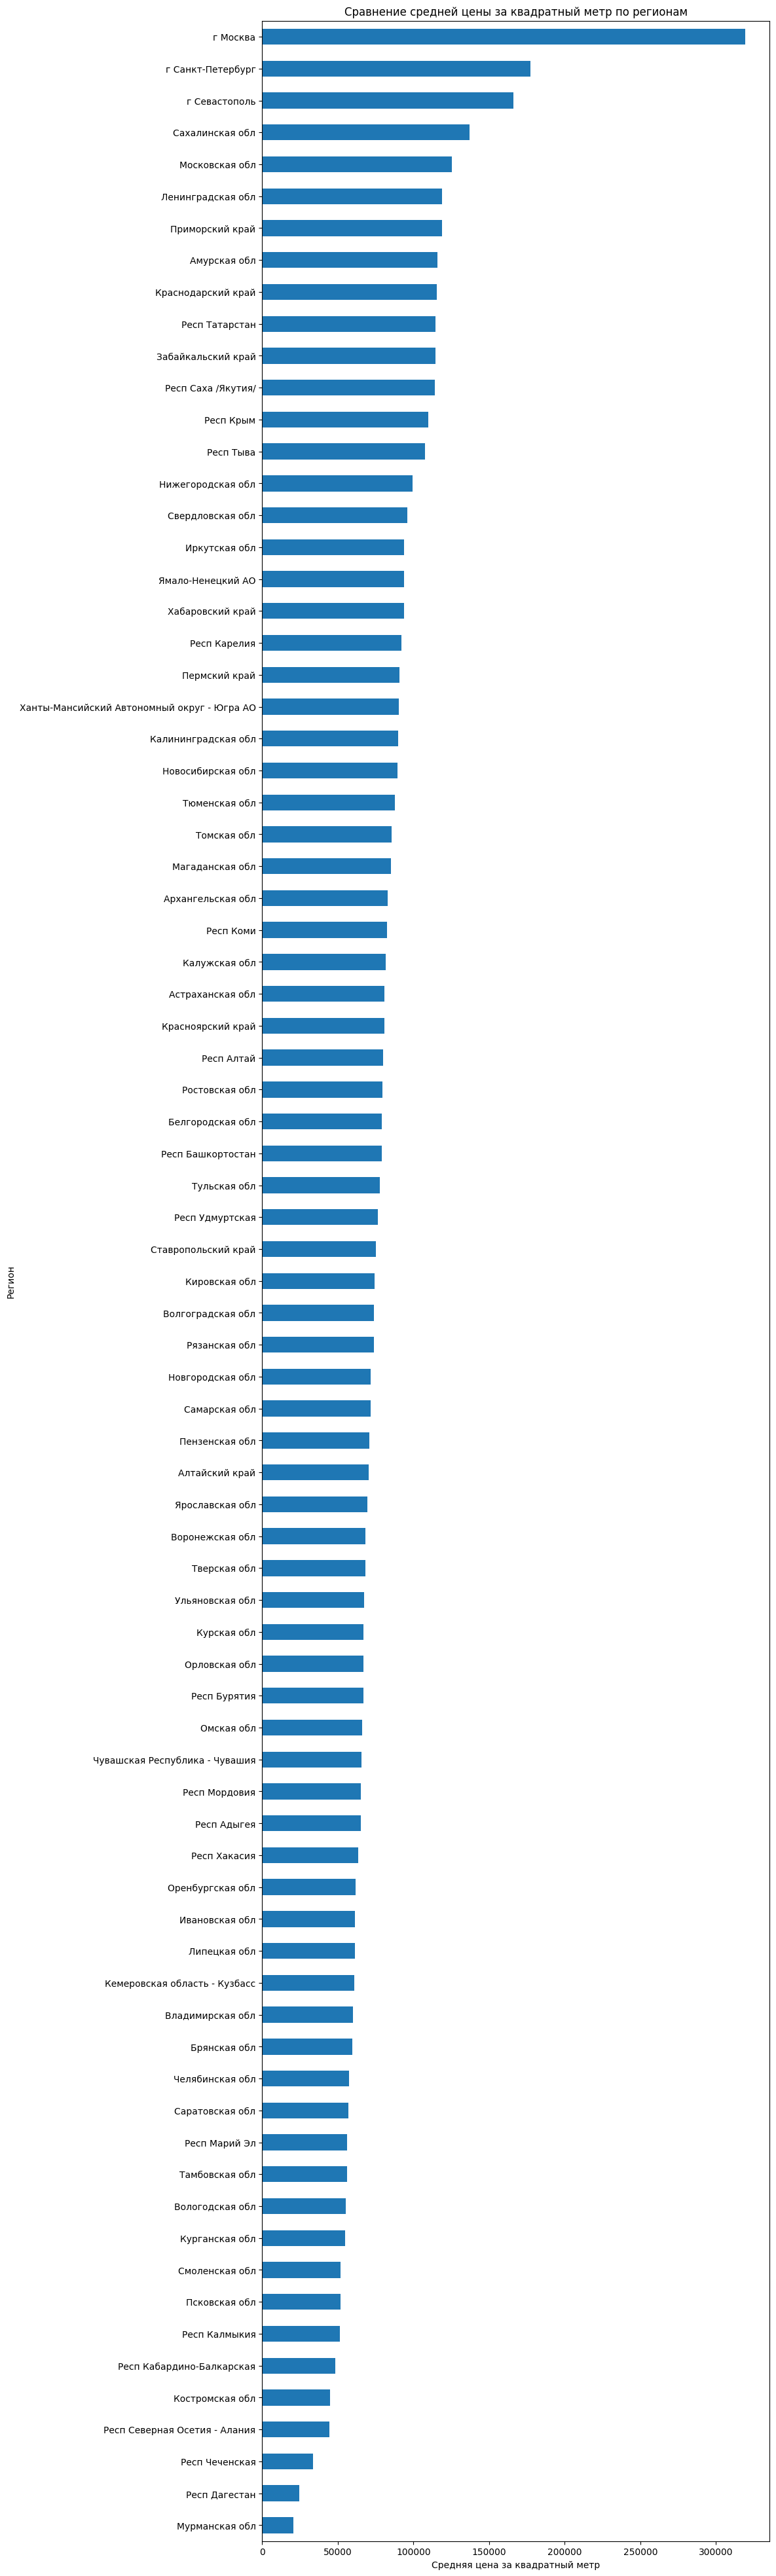

In [365]:
vis.make_boxplot('objPriceAvg') # вывожу один график, для простоты работы с jupyter notebook

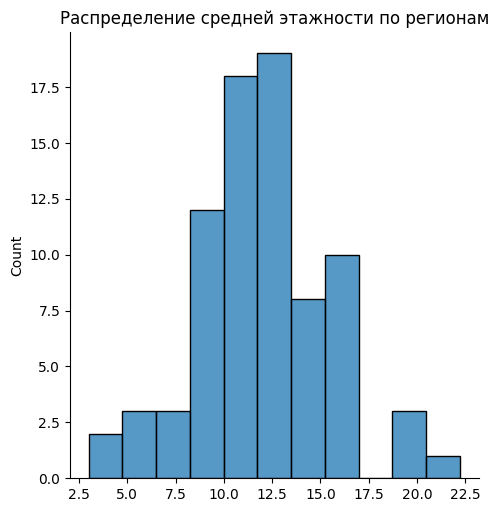

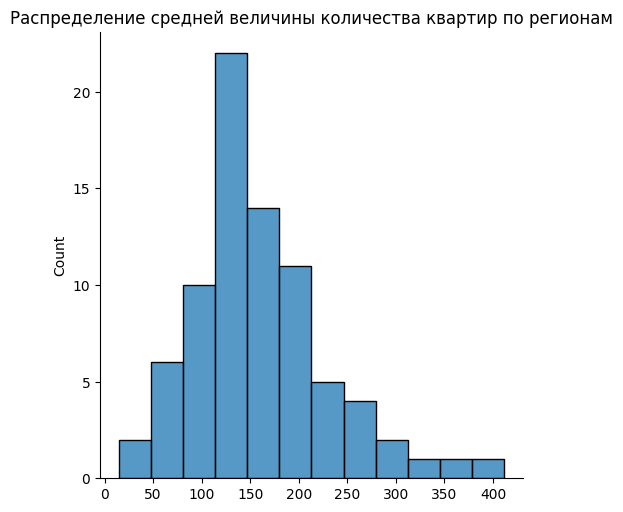

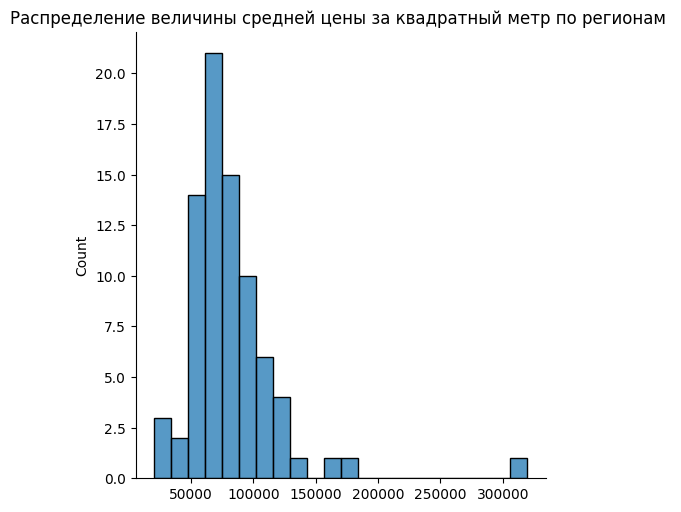

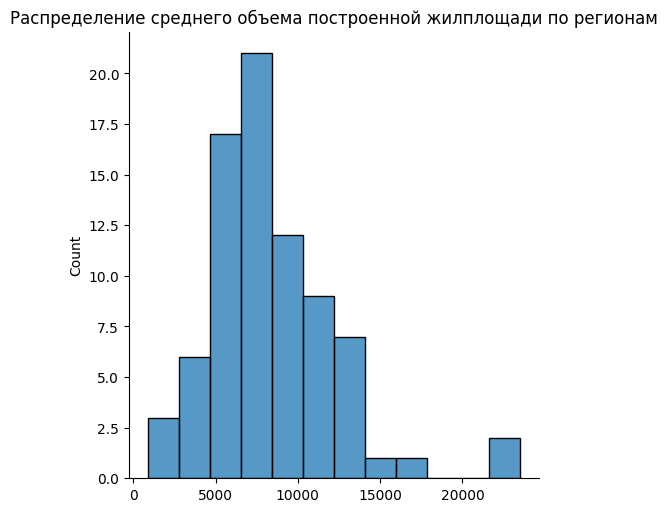

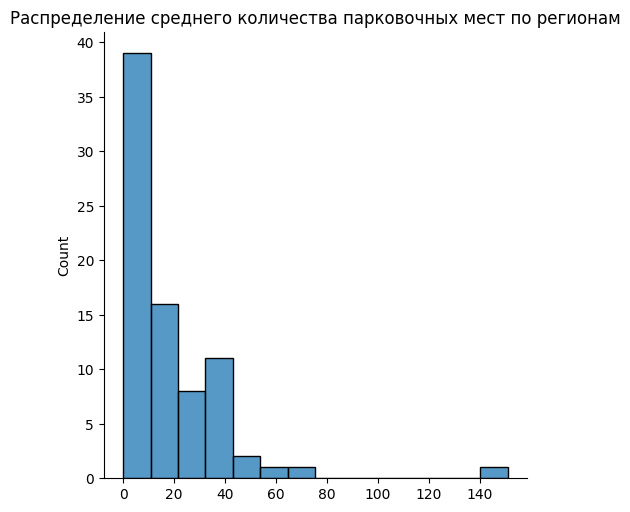

In [366]:
for a in vis.get_available_metrics_to_compare():
    vis.make_distribution(a)

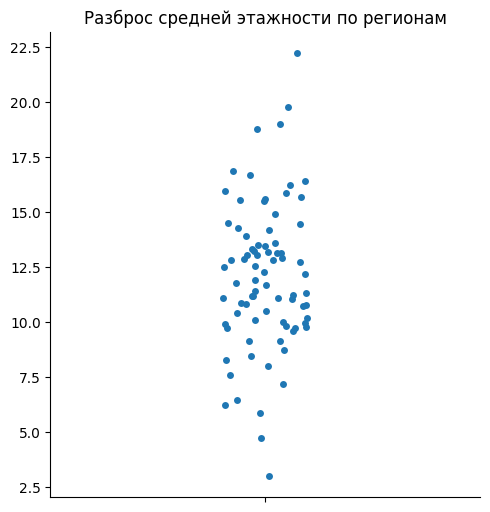

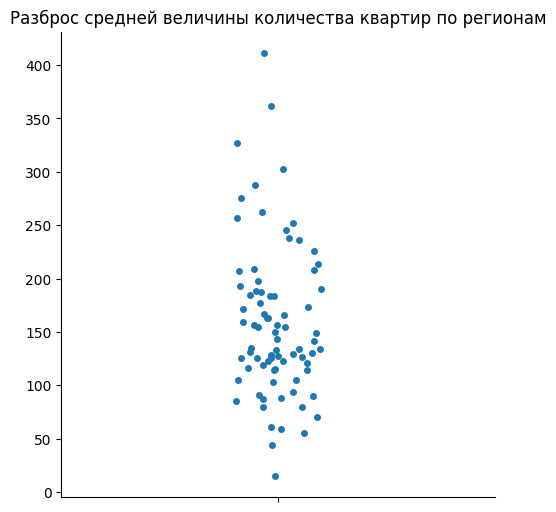

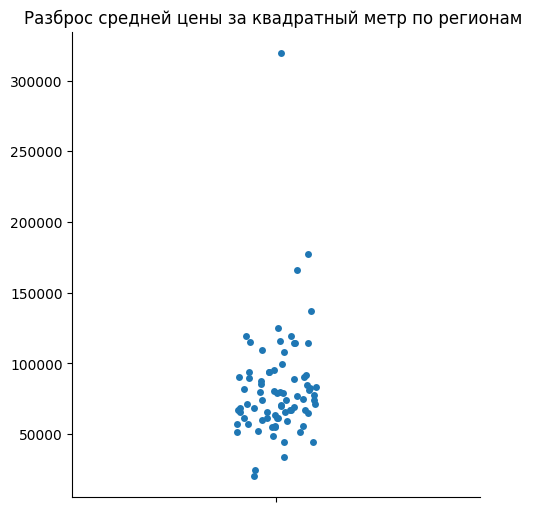

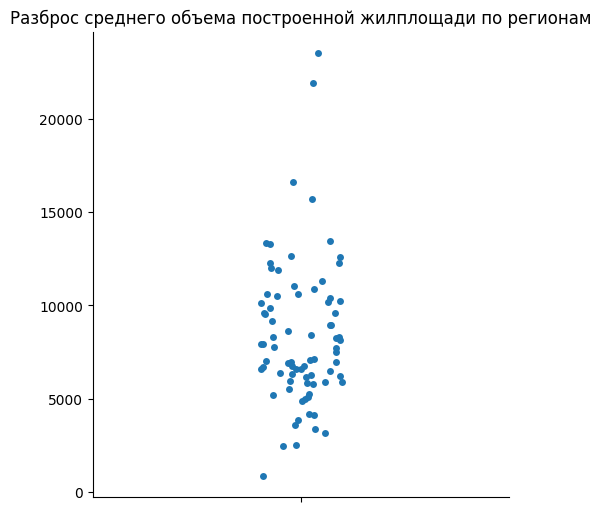

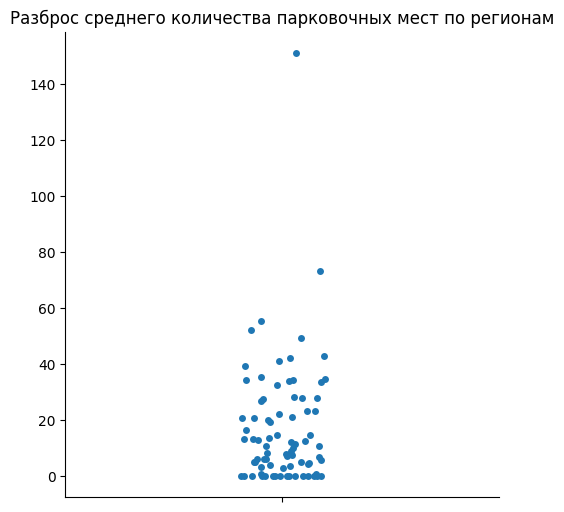

In [367]:
for a in vis.get_available_metrics_to_compare():
    vis.make_dispersion(a)

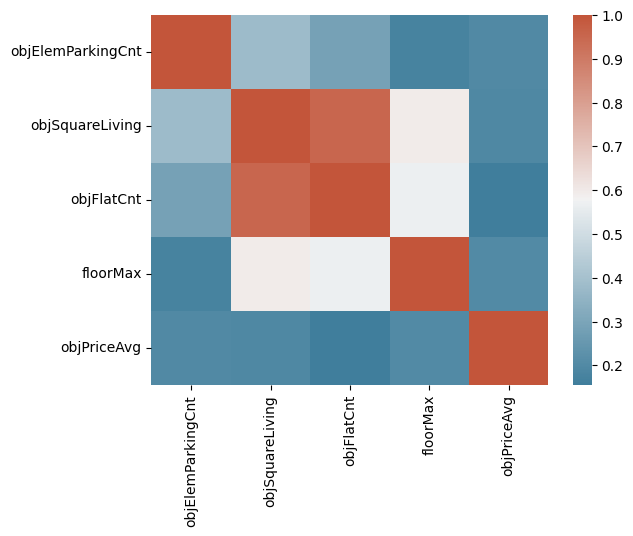

In [368]:
vis.make_heatmap()

Выявлена корреляция между параметрами:
 - количество парковочных мест и размер жилой площади
 - количество парковочных мест и количество квартир
 - количество квартир и размер жилой площади